In [33]:
import numpy as np
import numpy.random as npr
npr.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
# cm = plt.get_cmap('tab20')
# patient_colors = {p: cm(i) for i,p in enumerate(adata.obs['Patient'].unique())}
patient_colors = {
    '3229': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    '1767': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
    '1933': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    '2165': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
    '443': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
    '924': (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
    '1943': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    '1859': (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
    '2530': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
    '2184': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
    '3521': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
    '2887': (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
    '2089': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
    '3356': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0),
    '1263': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
    '2000': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
    '1804': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
    '1312': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883, 1.0)
}

In [3]:
df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)
# df = df.dropna()

# Some images are associated with multiple genes (i.e. nonspecific antibody); we remove these.
df['duplicated'] = df.index.value_counts()[df.index] > 1

# Only include high-quality images.
df = ( df.query('(Staining=="high")|(Staining=="medium")')
         .query('Reliability=="Enhanced"')
         .query('~duplicated') )

df = df.query('Patient!=1312')

# rna = pd.read_csv('./data/kidney_rna.csv',index_col=0)
# cell_type = rna.idxmax(1).rename('cell_type')
# df = df.join(cell_type,on='Gene',how='inner')

len(df)

10163

Donors are clearly imbalanced: excepting donor 1312, which has only one sample, largest donor has 35x more samples than smallest donor.

<AxesSubplot:>

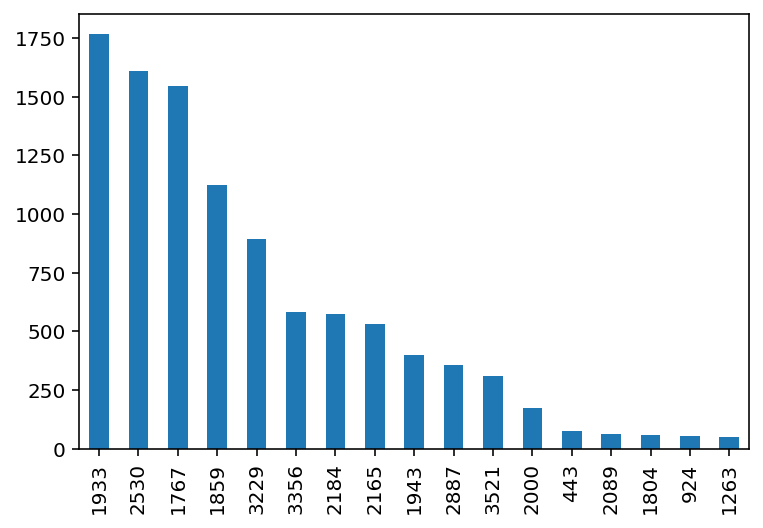

In [4]:
df['Patient'].value_counts().plot(kind='bar')

Positive pairs overwhelmingly come from the same batch.

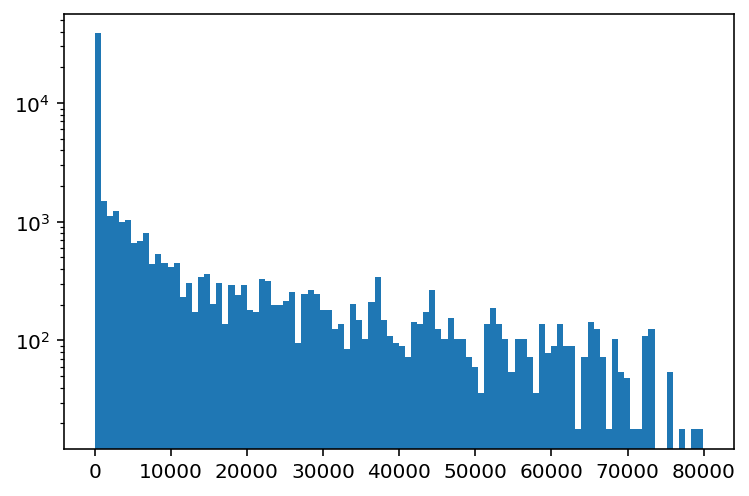

In [5]:
deltas = pd.Series([abs(p-q) for g, df_g in df.groupby('Gene') for p in df_g['Batch'] for q in df_g['Batch']])
plt.hist(deltas,bins=100,log=True);
# deltas.value_counts()

In [347]:
df.groupby('Gene')['Patient'].nunique().value_counts()

3    1457
6     198
5     173
4     163
2      75
7      22
8       9
9       6
1       3
Name: Patient, dtype: int64

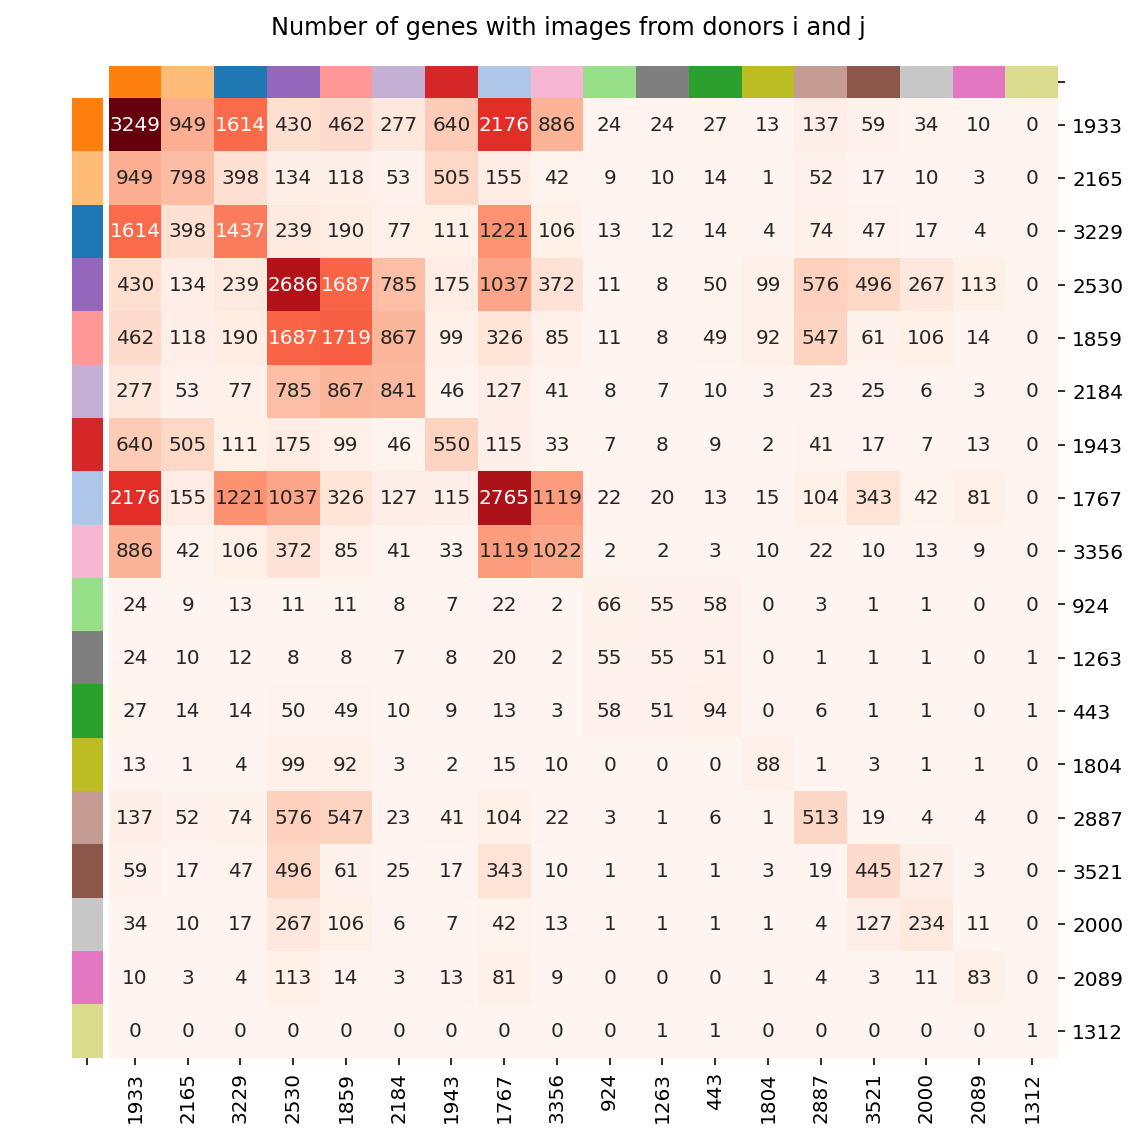

In [345]:
mat = donor_pairings.astype(int)
g = sns.clustermap(mat,method='ward',fmt='d',cmap='Reds',
                   row_colors=cs,col_colors=cs,annot=mat,dendrogram_ratio=0.05,
                   row_cluster=False,col_cluster=False,
                  figsize=(8,8))
g.cax.set_visible(False)
g.fig.suptitle('Number of genes with images from donors i and j')
plt.savefig('./figures/donor_counts.png',dpi=300)

What's the probability of a positive pair having donor i given it already has donor j?

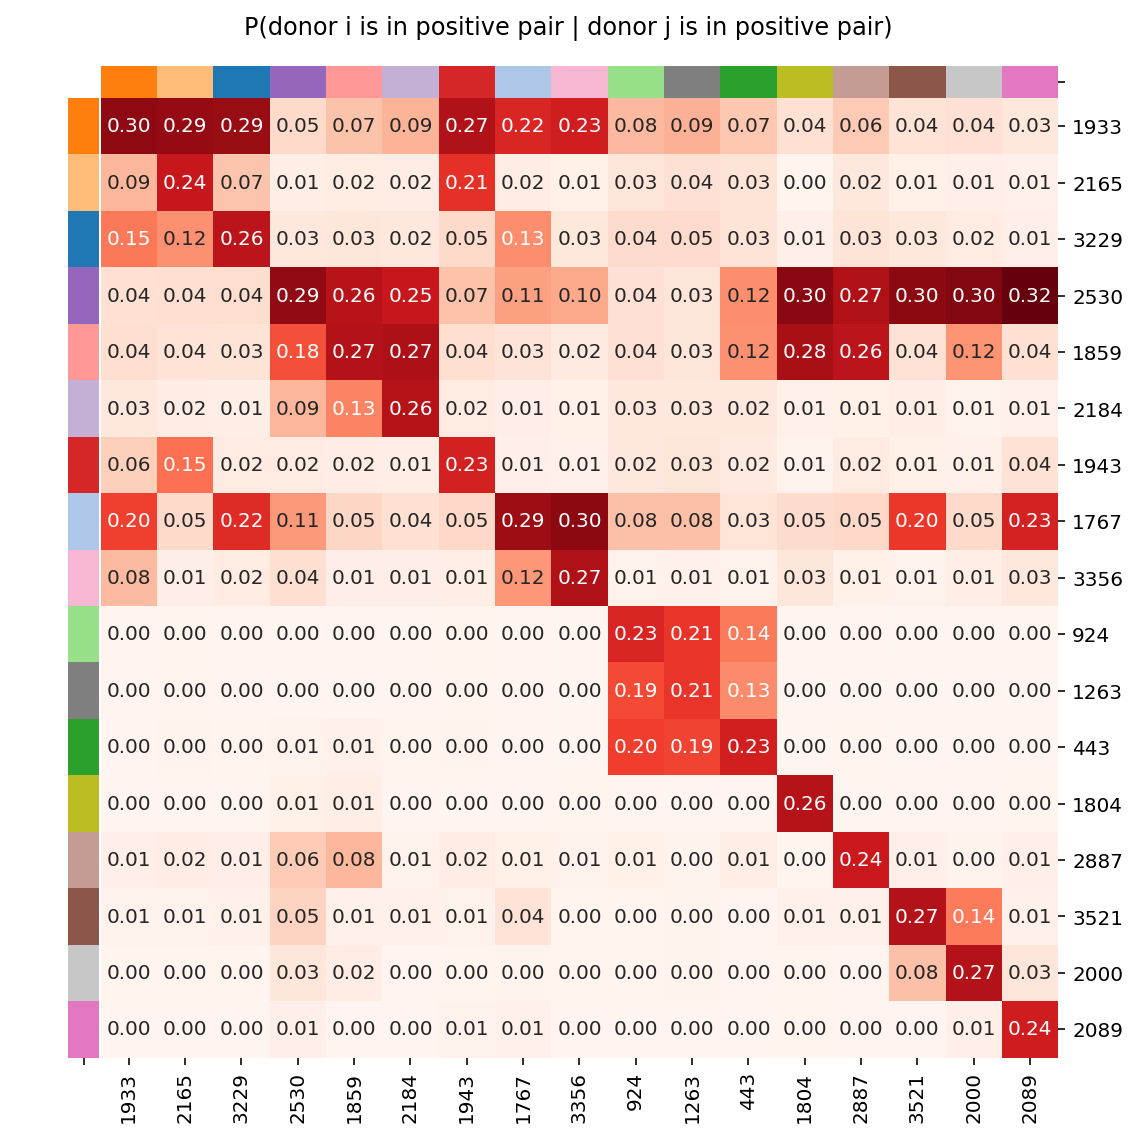

In [344]:
# from scipy.stats import entropy
# df.groupby('Gene')['Patient'].value_counts().groupby('Gene').agg(lambda x: entropy(x,base=3)).hist(bins=100);
donors = df['Patient'].unique()
donor_pairings = {dd:{d:0. for d in donors} for dd in donors}
for g, df_g in df.groupby('Gene'):
    for p in df_g['Patient']:
        for q in df_g['Patient']:
#             if p==q: continue
            donor_pairings[p][q] += 1.
donor_pairings = pd.DataFrame(donor_pairings)

mat = donor_pairings / donor_pairings.sum(0)
mat = mat.drop(index=1312).drop(columns=1312)
cs = pd.Series(patient_colors)
cs.index = cs.index.astype(int)
g = sns.clustermap(mat,cmap='Reds',method='ward',fmt='.2f',
                   row_colors=cs,col_colors=cs,annot=mat,dendrogram_ratio=0.05,
                   row_cluster=False,col_cluster=False,
                  figsize=(8,8))
g.cax.set_visible(False)
g.fig.suptitle('P(donor i is in positive pair | donor j is in positive pair)')
plt.savefig('./figures/donor_cpt.png',dpi=300)

In [267]:
# import networkx as nx

# G = nx.from_numpy_matrix(donor_pairings.values / null_pairings.values * 100)
# G = nx.relabel_nodes(G, dict(enumerate(donors.astype(str))))
# # G.remove_node('1312') # only one image
# n_donors = df['Patient'].value_counts()
# n_donors.index = n_donors.index.astype(str)
# plt.figure(figsize=(8,8))
# npr.seed(0)
# pos = nx.spring_layout(G,k=.5)
# nx.draw(G, pos=pos,
#      with_labels=True,
#      width=[w*0.001 for u,v,w in G.edges(data='weight')],
#      node_size=[(n_donors[v]) for v in G],
#      node_color=[patient_colors[v] for v in G])
# # nx.draw_networkx_edge_labels(
# #     G, pos,
# #     edge_labels={(u,v):int(donor_pairings[int(u)][int(v)]) for u,v,w in G.edges(data='weight')},
# # )
# plt.title('Co-occurrence of patients in genes')
# plt.savefig('./figures/patient_graph.png',dpi=300)

In [164]:
fn = './data/kidney_nonegatives_embeddings.csv'
name = fn.split('/')[-1].replace('.csv','')
embeddings = pd.read_csv(fn,index_col=0)

adata = embeddings.join(df, how='inner')
adata = sc.AnnData(adata[embeddings.columns], obs=adata.drop(columns=embeddings.columns))

sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata, min_dist=0.5)

# sc.tl.leiden(adata, resolution=0.2)

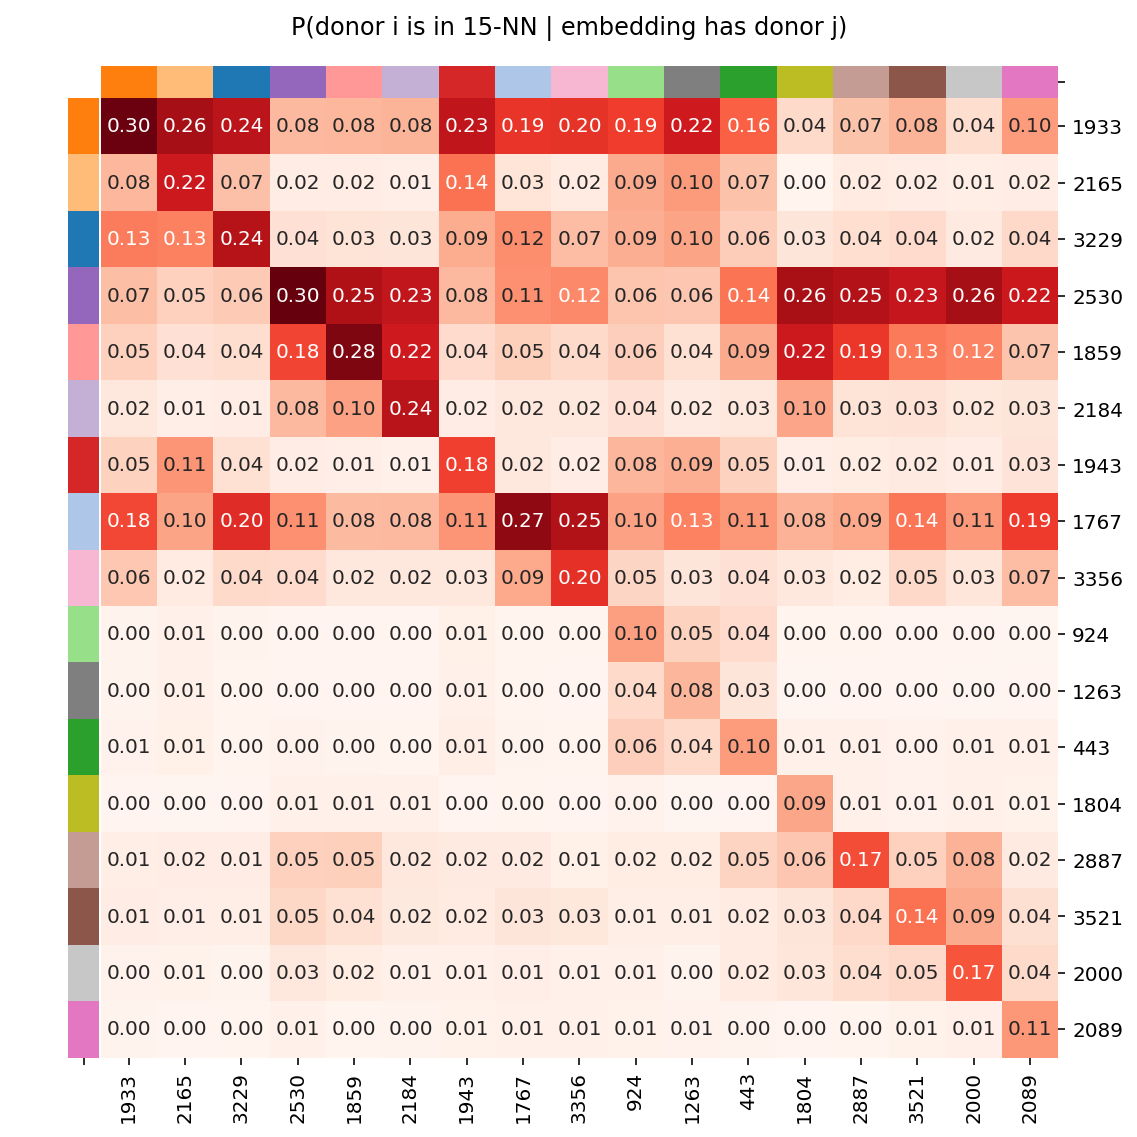

In [324]:
donors = df['Patient'].unique()
knn_pairings = {dd:{d:0. for d in donors} for dd in donors}
# for g, df_g in df.groupby('Gene'):
#     for p in df_g['Patient']:
#         for q in df_g['Patient']:
# #             if p==q: continue
#             donor_pairings[p][q] += 1.
# donor_pairings = pd.DataFrame(donor_pairings)

patient = adata.obs['Patient'].values
for p in patient:
    knn_pairings[p][p] += 1
for (i, j) in zip(*adata.obsp['distances'].nonzero()):
    knn_pairings[patient[i]][patient[j]] += 1.
knn_pairings = pd.DataFrame(knn_pairings)

mat = knn_pairings / knn_pairings.sum(0)
mat = mat.drop(index=1312).drop(columns=1312)
cs = pd.Series(patient_colors)
cs.index = cs.index.astype(int)
g = sns.clustermap(mat,cmap='Reds',method='ward',fmt='.2f',
                   row_colors=cs,col_colors=cs,annot=mat,dendrogram_ratio=0.05,
                   row_cluster=False,col_cluster=False,
                  figsize=(8,8))
g.cax.set_visible(False)
g.fig.suptitle('P(donor i is in 15-NN | embedding has donor j)')
plt.savefig('./figures/knn_cpt.png',dpi=300)

In [265]:
# # from scipy.stats import entropy
# # df.groupby('Gene')['Patient'].value_counts().groupby('Gene').agg(lambda x: entropy(x,base=3)).hist(bins=100);
# donors = df['Patient'].unique()
# leiden_pairings = {dd:{d:0. for d in donors} for dd in donors}
# for g, df_g in adata.obs.groupby('leiden'):
#     for p in df_g['Patient']:
#         for q in df_g['Patient']:
#             if p==q: continue
#             leiden_pairings[p][q] += 1.
# leiden_pairings = pd.DataFrame(leiden_pairings)
# leiden_pairings.values[:] /= leiden_pairings.values.sum()

In [266]:
# plt.figure(figsize=(5,5))
# plt.loglog(donor_pairings.values.ravel() / null_pairings.values.ravel(),leiden_pairings.values.ravel() / null_pairings.values.ravel(),'.')
# plt.xlabel(r'$\frac{Empirical probability of positive pair with these two donors}{probability if independent}$')
# plt.ylabel(r'$\frac{Empirical probability of these two donors being in same Leiden cluster}{probability if independent}$')

Is donor identity confounded with cell type?

In [ ]:
plt.figure(figsize=(18,6))
sns.barplot(
    data=df.groupby('cell_type')['Patient'].value_counts().rename('count').reset_index(),
    x='Patient',
    y='count',
    hue='cell_type',
    order=df['Patient'].value_counts().index,
    hue_order=df['cell_type'].value_counts().index,
)

Is donor identity confounded with batch? Yes - donors are not uniformly distributed across batches. In particular, sort-of three clusters.

In [ ]:
sns.stripplot(
    data=df,
    order=df.groupby('Patient')['Batch'].mean().sort_values().index,
    y='Patient',
    x='Batch',
    orient='h',
    size=1,
    jitter=0.25
)

In [ ]:
df['Batch'].hist(bins=100);

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score

ami = adjusted_mutual_info_score(
    df['cell_type'],
    df['Patient']
)
ami

How often does a gene have multiple images from the same donor? Surprisingly often, actually.

In [ ]:
multiplicity = (df.groupby('Gene')['Patient'].count() / df.groupby('Gene')['Patient'].nunique())
multiplicity.mean(), (multiplicity > 1).mean()

Roughly two clusters of patients that tend to cooccur within same genes.

In [ ]:
import itertools as it
nodes = df['Patient'].unique()
G = {u: {v: 0 for v in nodes} for u in nodes}
for _, ps in df.groupby('Gene')['Patient']:
    for u,v in it.combinations(list(ps),2):
        if u==v: continue
        G[u][v] += 1
        G[v][u] += 1
G = pd.DataFrame(G)
sns.clustermap(G,method='ward',annot=G,fmt='d',cmap='Reds') 

Is (transcriptomic) cell type confounded with patient?

In [ ]:
from sklearn.metrics import confusion_matrix

mat = (   df.join(cell_type,on='Gene',how='inner')
            .groupby('Patient')['cell_type']
            .value_counts()
            .rename('count')
            .reset_index()
            .pivot_table(index='Patient',columns='cell_type',fill_value=0)['count']
)
mat = mat.loc[mat.sum(1)>1]

# sns.clustermap(mat.T / mat.T.sum(0),annot=mat.T,fmt='d',cmap='Reds',method='ward',figsize=(12,6))
sns.clustermap(mat.T,annot=mat.T,fmt='d',cmap='Reds',method='ward',figsize=(12,6))

In [10]:
# What do effects look like across donors?
# from imageio import imread
# from PIL import Image
# from IPython.display import display

# for donor in df.groupby('Patient')['Batch'].mean().sort_values().index:
#     imgs = []
#     for name, row in df.query(f'Patient=={donor}').sample(n=10,random_state=0,replace=True).sort_values('Batch').iterrows():
#         batch = row['Batch']
#         imgs.append(imread(f'./data/images/kidney/{batch}/{name}.png')[::2,::2])
#     display(Image.fromarray(np.concatenate(imgs,axis=1)))

# Do the different strategies make ID'ing the donor harder?
yes they do!

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score

df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)
df = df.query('Patient!=1312') # drop this singleton class, messes with converegnce

# Some images are associated with multiple genes (i.e. nonspecific antibody); we remove these.
df['duplicated'] = df.index.value_counts()[df.index] > 1

# Only include high-quality images.
df = ( df.query('(Staining=="high")|(Staining=="medium")')
         .query('Reliability=="Enhanced"')
         .query('~duplicated') )

accs = {}

for fn in [
    './data/kidney_nogrouping_embeddings.csv', # augmentations only
    './data/kidney_nonegatives_embeddings.csv', # + gene grouping
    './data/kidney_positives_embeddings.csv', # filtering positives instead of negatives
    './data/kidney_final_embeddings.csv', # + negative sampling
]:
    name = fn.split('/')[-1].replace('.csv','')
    embeddings = pd.read_csv(fn,index_col=0)

    index = list(set(embeddings.index)&set(df.index))
    npr.seed(0)
    npr.shuffle(index)
    X = scale(embeddings.loc[index].values)
    y = df.loc[index]['Patient'].values

    lm = LogisticRegression(penalty='none',random_state=0,max_iter=1000)
    acc = cross_val_score(lm, X, y, cv=5, n_jobs=5).mean()
    accs[name] = acc

/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [31]:
pd.Series(accs,name='accuracy').to_frame()

accuracy
kidney_nogrouping_embeddings   0.618221
kidney_nonegatives_embeddings  0.393977
kidney_final_embeddings        0.293713
kidney_positives_embeddings    0.579553

... storing 'Well' as categorical
... storing 'Tissue' as categorical
... storing 'Gene name' as categorical
... storing 'Gene' as categorical
... storing 'UniProt' as categorical
... storing 'Antibody' as categorical
... storing 'Staining' as categorical
... storing 'Sex' as categorical
... storing 'Patient' as categorical
... storing 'Level' as categorical
... storing 'Reliability' as categorical
... storing 'Well' as categorical
... storing 'Tissue' as categorical
... storing 'Gene name' as categorical
... storing 'Gene' as categorical
... storing 'UniProt' as categorical
... storing 'Antibody' as categorical
... storing 'Staining' as categorical
... storing 'Sex' as categorical
... storing 'Patient' as categorical
... storing 'Level' as categorical
... storing 'Reliability' as categorical
... storing 'Well' as categorical
... storing 'Tissue' as categorical
... storing 'Gene name' as categorical
... storing 'Gene' as categorical
... storing 'UniProt' as categorical
... storing 'Ant

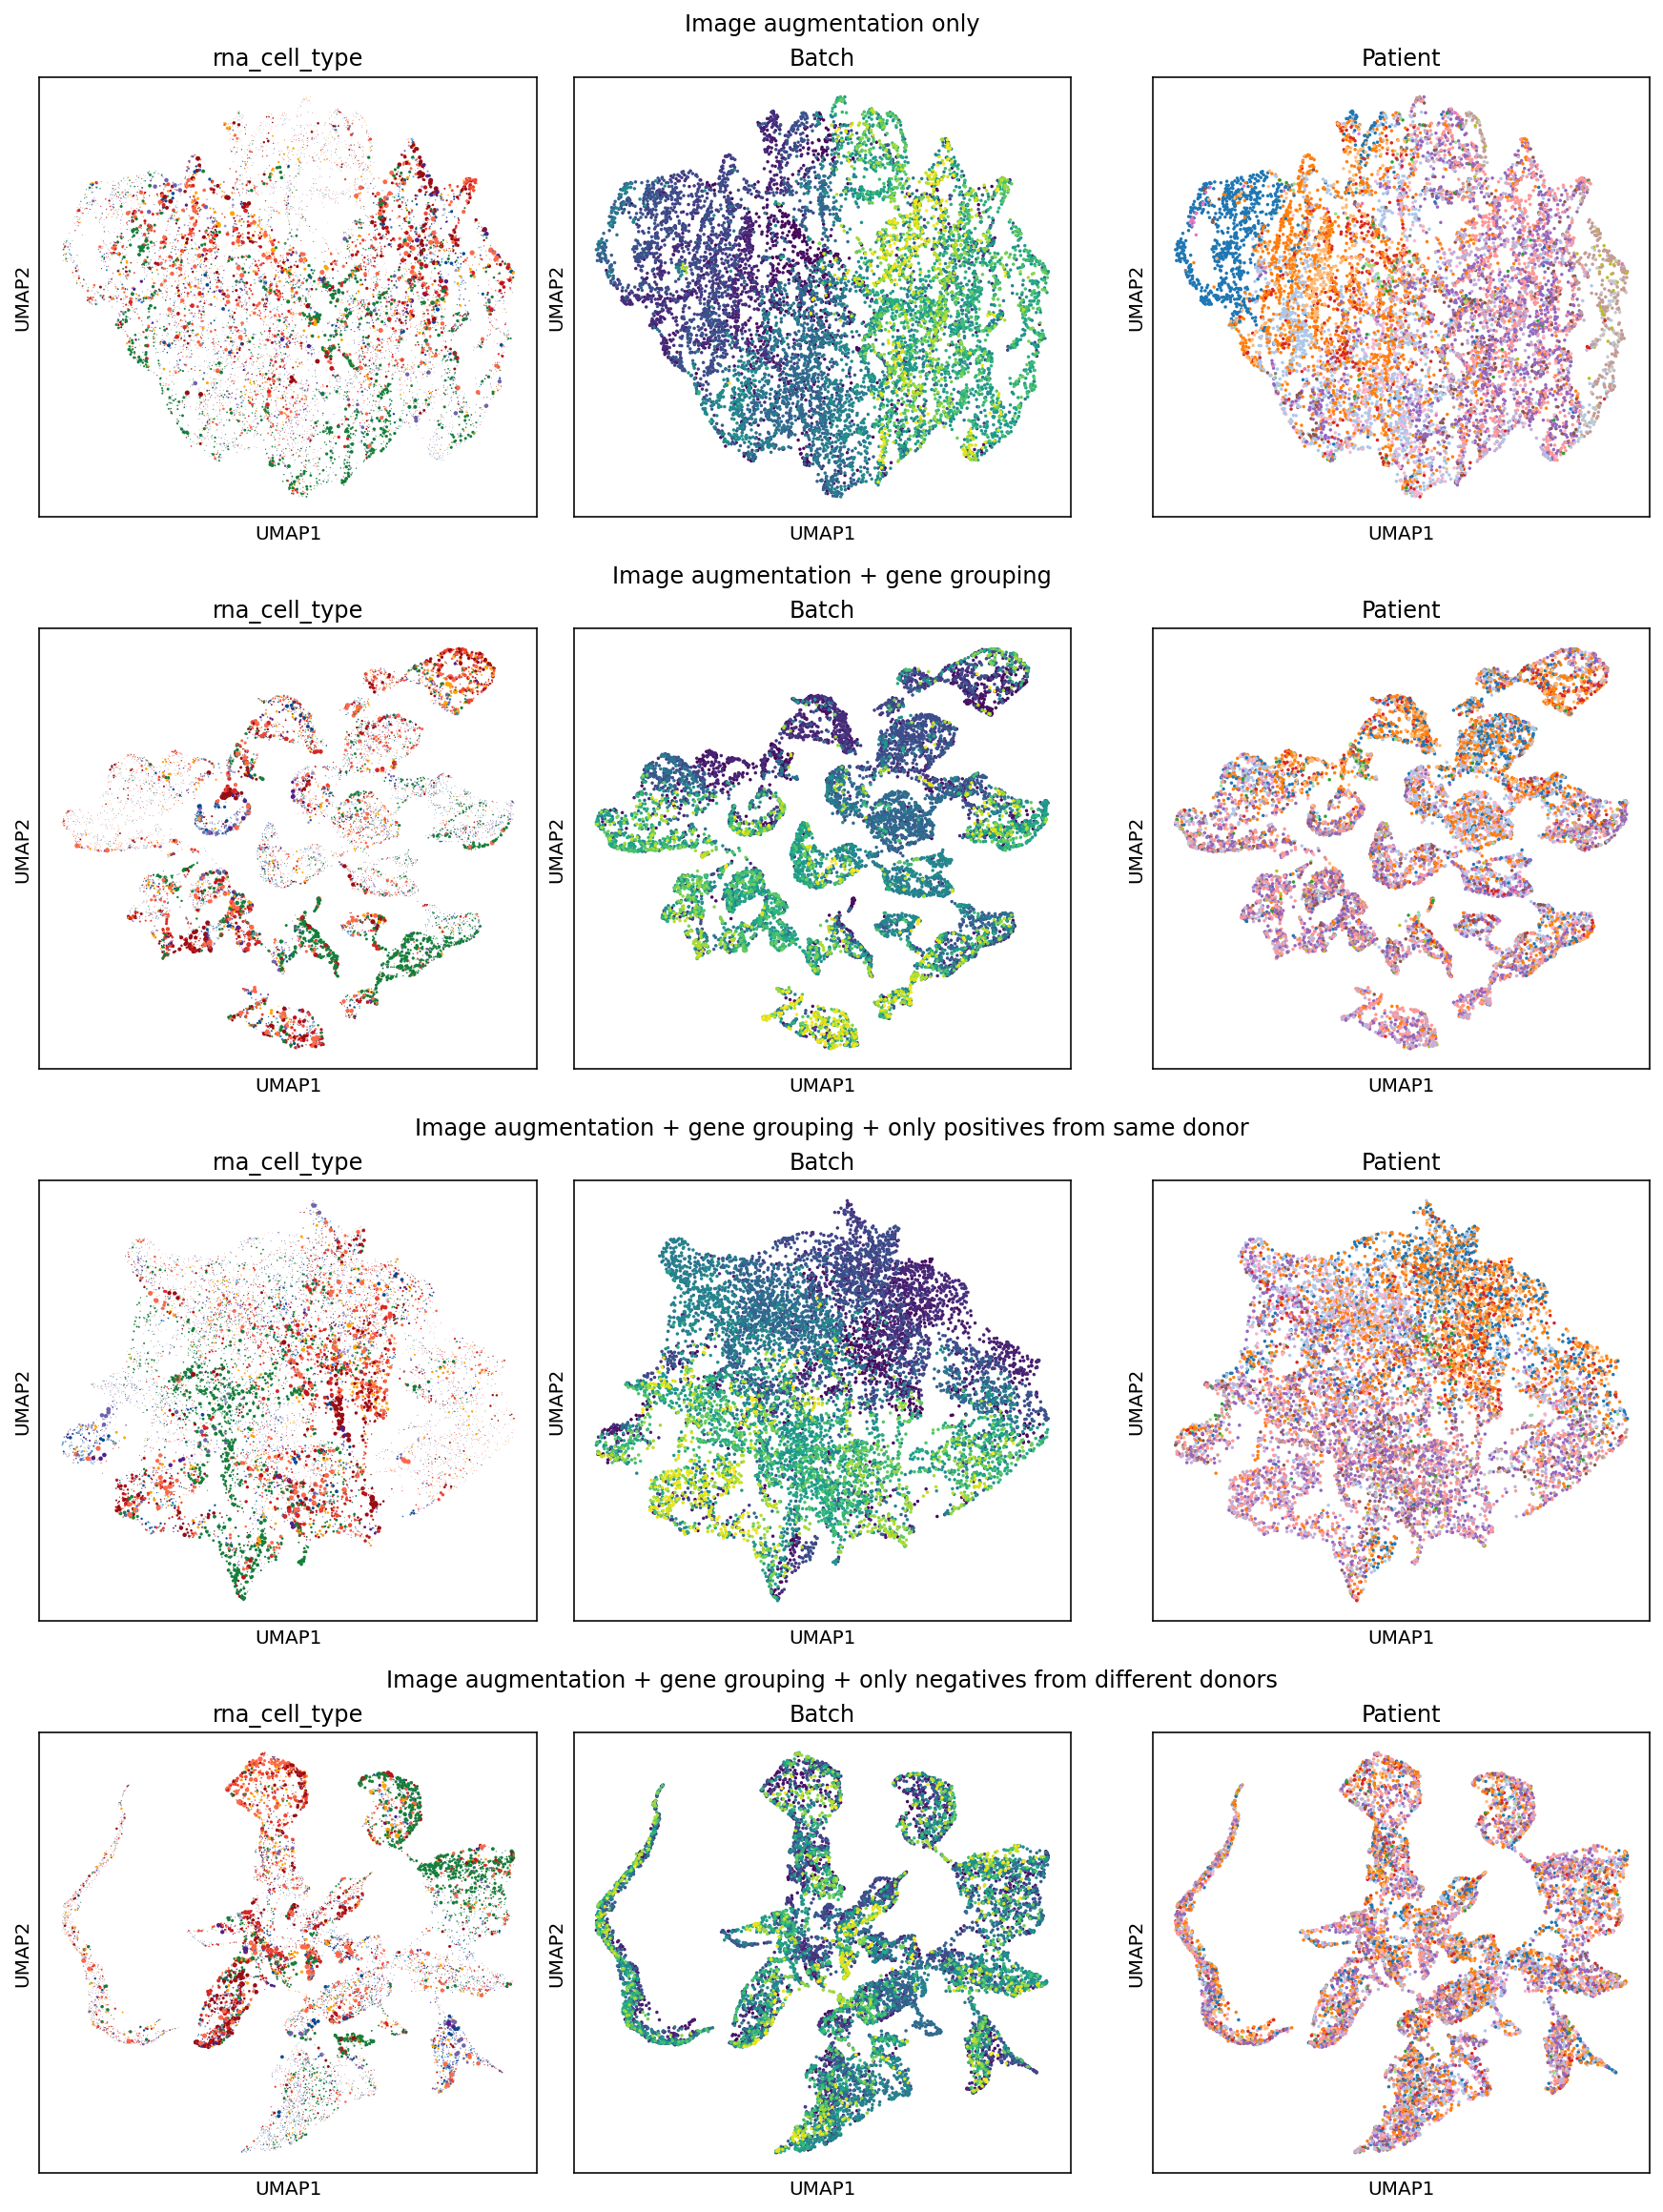

In [93]:
from figures.cell_type_colors import cell_type_colors

df = pd.read_csv(f'./data/hpa_v21_kidney.csv',index_col=0)
df['duplicated'] = df.index.value_counts()[df.index] > 1
df = ( df.query('(Staining=="high")|(Staining=="medium")')
         .query('(Reliability=="Enhanced")')
         .query('~duplicated') )

rna = pd.read_csv(f'./data/kidney_rna.csv',index_col=0)

figsize=4
figs = plt.figure(constrained_layout=True,figsize=(3*figsize,4*figsize)).subfigures(4, 1)

names = [
    'Image augmentation only',
    'Image augmentation + gene grouping',
    'Image augmentation + gene grouping + only positives from same donor',
    'Image augmentation + gene grouping + only negatives from different donors',
]

for i,fn in enumerate([
    './data/kidney_nogrouping_embeddings.csv', # augmentations only
    './data/kidney_nonegatives_embeddings.csv', # + gene grouping
    './data/kidney_positives_embeddings.csv', # filtering positives instead of negatives
    './data/kidney_final_embeddings.csv', # + negative sampling
]):
    name = fn.split('/')[-1].replace('.csv','')
    embeddings = pd.read_csv(fn,index_col=0)
    
    adata = embeddings.join(df, how='inner').join(rna, on='Gene', how='inner')
    adata = sc.AnnData(adata[embeddings.columns], obs=adata.drop(columns=embeddings.columns))
    adata.obs['Patient'] = adata.obs['Patient'].astype(str)
    
    adata.obs['rna_cell_type'] = adata.obs[rna.columns].idxmax(1)
    adata.obs['rna_specificity'] = adata.obs[rna.columns].max(1)
    adata.obs['rna_cell_type'] = ( adata.obs['rna_cell_type']
                                        .astype('category')
                                        .cat
                                        .reorder_categories(list(cell_type_colors['kidney'])) )


    sc.pp.neighbors(adata, use_rep='X')
    sc.tl.umap(adata, min_dist=0.5)
    
    fig = figs[i]
    axs = fig.subplots(1,3)
    fig.suptitle(names[i])

    sc.pl.umap(adata, color='rna_cell_type', palette=cell_type_colors['kidney'], s=adata.obs['rna_specificity']**2*30,  ax=axs[0], show=False)
    sc.pl.umap(adata, color='Batch', ax=axs[1], show=False)
    axs[1]._colorbars[0].set_visible(False)
    sc.pl.umap(adata, color='Patient', palette=patient_colors, ax=axs[2], show=False)
    for ax in axs:
        ax.legend().set_visible(False)
        
plt.savefig(f'./figures/compare_sampling.png', dpi=300);